In [146]:
import functools
import pathlib
import time
import itertools

import einops
import joblib
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from safetensors import numpy as safetensors

%matplotlib inline

## Understanding the data

| **Subset** | **Tile** | **# Samples** | **Resolution** |
|:-----------|:--------:|:-------------:|:--------------:|
| Training   |  T30TYQ  |  1884         |    1024x1024   |
| Validation |  T30TYR  |  2583         |    256x256     |

> CESBIO - Centre d'études spatiales de la biosphère. Unlabeled Sentinel 2 time series dataset (training: T30TYQ, validation: T30TYR). Zenodo, 2023. Available at: https://zenodo.org/records/7890542. Licensed under Creative Commons Attribution 4.0 International (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/.

In [2]:
data_folder = pathlib.Path("/p/scratch/training2504/data/s2l2a-sits")
train_set_folder = data_folder / "train"
val_set_folder = data_folder / "val"

In [52]:
sample = (train_set_folder / "SENTINEL2A_20200619-105853-505_L2A_T30TYQ_C_V2-2_patch_9.tif")

In [19]:
# sample = train_set_folder / "SENTINEL2A_20181117-105841-423_L2A_T30TYQ_C_V2-2_patch_6.tif"
# sample = val_set_folder/"SENTINEL2A_20171023-105154-753_L2A_T30TYR_D_V1-4_patch_6.tif"
# sample = val_set_folder/ "SENTINEL2B_20170822-110527-982_L2A_T30TYR_C_V2-2_patch_5.tif"

Data samples are encoded according to the [TIFF](https://en.wikipedia.org/wiki/TIFF) file format, and parsed using:
- [`xarray`](https://xarray.dev/): implements namespaced arrays and datasets
- [`rioxarray`](https://corteva.github.io/rioxarray/stable/): equips `xarray` with [`rasterio`](https://rasterio.readthedocs.io/en/latest/index.html) features

In [53]:
assert sample.exists(), "File not found."
dataset = xr.open_dataset(sample, engine="rasterio")
dataset

<xarray.Dataset> Size: 55MB
Dimensions:      (band: 13, x: 1024, y: 1024)
Coordinates:
  * band         (band) int64 104B 1 2 3 4 5 6 7 8 9 10 11 12 13
  * x            (x) float64 8kB 7.729e+05 7.729e+05 ... 7.832e+05 7.832e+05
  * y            (y) float64 8kB 4.979e+06 4.979e+06 ... 4.969e+06 4.969e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 55MB ...

In [21]:
def read_band(band, dataset):
    return dataset.sel(band=band).band_data.values

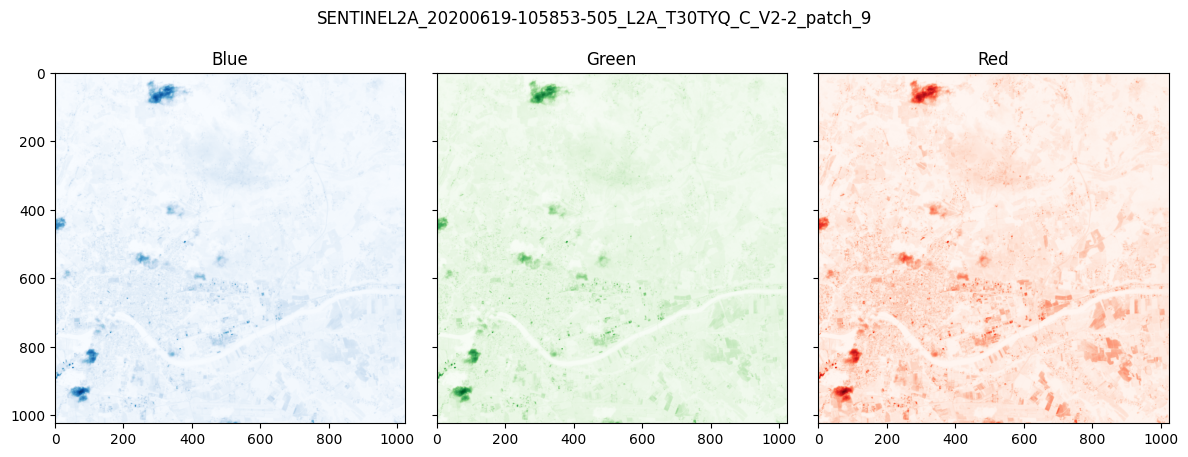

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12), sharey=True)
cmaps = ["Blues", "Greens", "Reds"]
images = [read_band(band, dataset=dataset) for band in range(1, 4)]
for idx, (cmap, image) in enumerate(zip(cmaps, images)):
    axes[idx].imshow(image, cmap=cmap)
    axes[idx].set_title(cmap[:-1])

fig.suptitle(str(sample.stem))
fig.tight_layout()
fig.subplots_adjust(top=1.55)

plt.show()

## Cloud filtering pipeline

In [63]:
cloud_confidence = 10 # Mark as cloudy all pixels whose CLP value is larger than 10%
pixel_ratio = 0.1     # Ratio of cloudy pixels allowed inside a patch

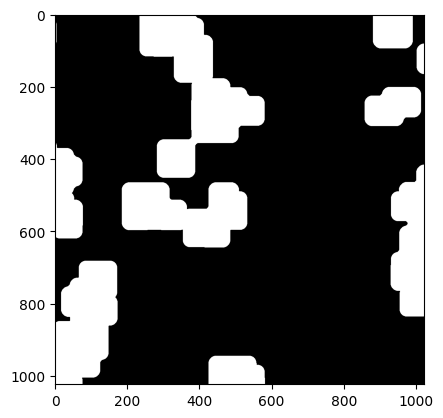

In [64]:
cloud_probs = read_band(band=11, dataset=dataset)
cloud_mask = (cloud_probs > cloud_confidence).astype(np.uint8)

plt.imshow(cloud_mask, cmap="Greys_r", vmin=0, vmax=1)
plt.show()

### Splitting samples into patches

**Goal**: split each (1024, 1024) sample image into a set of (256, 256) non-overlapping patches

In [66]:
pixel_values = dataset.sel(band=slice(1, 11)).band_data.values
pixel_values.shape

(11, 1024, 1024)

In [67]:
def patchify(image, patch_size):
    num_channels, height, width = image.shape
    patches = (
        image.reshape(
            num_channels, height // patch_size, patch_size, width // patch_size, patch_size
        )
        .transpose(1, 3, 0, 2, 4)
        .reshape(-1, num_channels, patch_size, patch_size)
    )

    return patches

In [68]:
patches = patchify(pixel_values, patch_size=256)
#patches = einops.rearrange(pixel_values, "c (h p1) (w p2) -> (h w) c p1 p2", p1=256, p2=256)
patches.shape

(16, 11, 256, 256)

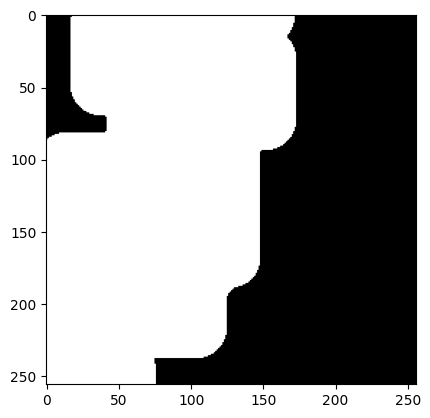

In [135]:
cloud_probs = patches[12, 10]
cloud_mask = (cloud_probs > cloud_confidence).astype(np.uint8)

plt.imshow(cloud_mask, cmap="Greys_r", vmin=0, vmax=1)
plt.show()

In [136]:
num_channels, orig_size = pixel_values.shape[0], pixel_values.shape[-1]
patch_size = patches.shape[-1]
strides = itertools.product(range(orig_size // patch_size), repeat=2)
for idx, stride in enumerate(strides):
    lrow, hrow = stride[0] * patch_size, (1 + stride[0]) * patch_size
    lcol, hcol = stride[1] * patch_size, (1 + stride[1]) * patch_size
    for cidx in range(num_channels):
        test = pixel_values[cidx, lrow:hrow, lcol:hcol]
        assert np.allclose(test, patches[idx, cidx]), print(cidx, idx, stride)  

print("👍")

👍


In [137]:
images, cloud_probs = patches[:, :-1], patches[:, -1]
print(images.shape, cloud_probs.shape, sep="\n")

(16, 10, 256, 256)
(16, 256, 256)


### Filtering out cloudy patches

**Goal**: computing the set of (local) indices corresponding to clear-sky patches

In [92]:
@np.vectorize(excluded={"confidence", "pixel_ratio"}, signature="(m,n)->()")
def iscloudy(cloud_probs, confidence, pixel_ratio):
    num_pixels = cloud_probs.size
    num_cloudy_pixels = (cloud_probs > confidence).sum()

    return num_cloudy_pixels > np.ceil(pixel_ratio * num_pixels)

In [150]:
def filter_cloudy(cloud_probs, **kwargs):
    clearsky_indices = np.where(iscloudy(cloud_probs, **kwargs)==False)[0]
    
    return clearsky_indices 

In [151]:
clearsky_indices = filter_cloudy(cloud_probs, confidence=10, pixel_ratio=0.1)
clearsky_indices

array([ 0,  2,  6, 10, 14, 15])

In [114]:
clearsky_patches = images[clearsky_indices]
clearsky_patches.shape

(6, 10, 256, 256)

### Storing the spectral bands from clear-sky patches

**Goal**: Store clear-sky patches as [`safetensors`](https://huggingface.co/docs/safetensors/index).

In [96]:
def rename_patch(sample_path, patch_idx, num_patches):
    assert patch_idx <= num_patches - 1, f"Patch index should be less or equal to the number of patches. Got index {patch_idx} but the number of patches is {num_patches}"
    
    digits = len(str(num_patches))
    sample_name_tokens = sample_path.stem.split("_")
    
    basename = "_".join(sample_name_tokens[i] for i in [0, 1, -2, -1])
    counter = f"{patch_idx+1:0{digits}d}-of-{num_patches}"
    return f"{basename}_subpatch_{counter}"

In [107]:
root_processed = pathlib.Path("/p/scratch/training2504/maurogiovanni1/data/s2l2a-patches")
train_processed = root_processed / "train"
train_processed.mkdir(parents=True, exist_ok=True)

In [121]:
num_patches = (orig_size // patch_size) ** 2
for idx in clearsky_indices:
    tensor_dict = {"data": images[idx].astype(np.int16)}
    patch_name = rename_patch(sample, patch_idx=idx, num_patches=num_patches)
    safetensors.save_file(tensor_dict, train_processed/f"{patch_name}.safetensors")

In [124]:
file_path = train_processed / "SENTINEL2A_20200619-105853-505_patch_9_subpatch_07-of-16.safetensors"
loaded = safetensors.load_file(file_path)
loaded["data"].dtype

dtype('int16')

In [132]:
assert np.allclose(loaded["data"], clearsky_patches[2])
print("👍")

👍


### Processing all the samples through the pipeline

**Goal**: Perform cloud filtering on all the training sample in parallel

In [138]:
def cloud_filter_pipeline(src_path, dest_path, patch_size, dtype):
    # Read pixel values
    dataset = xr.open_dataset(src_path, engine="rasterio")
    pixel_values = dataset.sel(band=slice(1, 11)).band_data.values
    # Chunk pixel values into patches
    patches = einops.rearrange(pixel_values, "c (h p1) (w p2) -> (h w) c p1 p2", p1=patch_size, p2=patch_size)
    # Separate spectral bands from cloud probabilities
    multispectral, cloud_probs = patches[:, :-1], patches[:, -1]
    # Calculate indices of clear-sky patches
    clearsky_indices = filter_cloudy(cloud_probs, confidence=10, pixel_ratio=0.1)
    # Save spectral bands from clear-sky patches
    if clearsky_indices.size == 0:
        return
    num_patches_x = pixel_values.shape[-1] // patch_size
    num_patches_y = pixel_values.shape[-2] // patch_size
    num_patches = num_patches_y * num_patches_x
    for idx in clearsky_indices:
        tensor_dict = {"data": multispectral[idx].astype(dtype)}
        patch_name = rename_patch(src_path, patch_idx=idx, num_patches=num_patches)
        safetensors.save_file(tensor_dict, dest_path/f"{patch_name}.safetensors")

In [142]:
train_samples = list(train_set_folder.glob("*.tif"))
num_samples = len(train_samples)

In [127]:
start = time.time()
for sample in train_samples:
    cloud_filter_pipeline(sample, dest_path=root_processed/"ptrain", patch_size=256, dtype=np.int16)
end = time.time()
print(f"Processed {num_samples} samples in {end-start:.1f}s.")

Processed 1884 samples in 310.7s.


In [143]:
closure = functools.partial(cloud_filter_pipeline, dest_path=root_processed/"train", patch_size=256, dtype=np.int16)
start = time.time()
joblib.Parallel(n_jobs=24, timeout=9999)(joblib.delayed(closure)(sample) for sample in train_samples)
end = time.time()
print(f"Processed {num_samples} samples in {end-start:.1f}s.")

Processed 1884 samples in 21.8s.


In [144]:
seq_file_root = root_processed/"train"
par_file_root = root_processed/"ptrain"
seq_file_paths, par_file_paths = map(lambda folder: list(folder.glob("*.safetensors")), (seq_file_root, par_file_root))

In [145]:
assert len(seq_file_paths) == len(par_file_paths)
for seq_path, par_path in zip(seq_file_paths, par_file_paths):
    assert seq_path.stem == par_path.stem
test_idxs = np.random.randint(len(seq_file_paths), size=(100,))
for idx in test_idxs:
    seq_values = safetensors.load_file(seq_file_paths[idx])
    par_values = safetensors.load_file(par_file_paths[idx])
    assert np.allclose(seq_values["data"], par_values["data"])

print("👍")

👍


## Preprocessed dataset

| **Subset** | **Tile** | **# Samples** | **Resolution** |
|:-----------|:--------:|:-------------:|:--------------:|
| Training   |  T30TYQ  |  15941        |    256x256   |
| Validation |  T30TYR  |  ❓           |    256x256     |

> CESBIO - Centre d'études spatiales de la biosphère. Unlabeled Sentinel 2 time series dataset (training: T30TYQ, validation: T30TYR). Zenodo, 2023. Available at: https://zenodo.org/records/7890542. Licensed under Creative Commons Attribution 4.0 International (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/.